# Data ingestion and imports

In [1]:
!pip install pingouin
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pingouin as pg

# Load the data
base_data = np.load('csg_strain_8000.npy')
base_params = np.load('csg_param_8000.npy')


print("Original data shape:", base_data.shape)
print("Original params shape:", base_params.shape)

def augment_signal(signal, noise_level=0.005, shift_max=10):
    # Add random noise
    noisy_signal = signal + noise_level * np.random.randn(*signal.shape)

    # Randomly choose a shift value between -shift_max and shift_max
    shift = np.random.randint(-shift_max, shift_max)

    if shift > 0:
        # Pad on the left and remove values from the right
        augmented_signal = np.pad(noisy_signal, ((0, 0), (shift, 0)), mode='constant')[:, :-shift]
    elif shift < 0:
        # Pad on the right and remove values from the left
        augmented_signal = np.pad(noisy_signal, ((0, 0), (0, -shift)), mode='constant')[:, -shift:]
    else:
        augmented_signal = noisy_signal

    return augmented_signal

# Pre-generate the augmented dataset
augmented_data = []
augmented_params = []

num_augmentations = 0  # Number of augmented versions per original sample

for sample, param in zip(base_data, base_params):
    # Add the original sample
    augmented_data.append(sample)
    augmented_params.append(param)

    # Generate additional augmented samples
    for _ in range(num_augmentations):
        aug_sample = augment_signal(sample)
        augmented_data.append(aug_sample)
        augmented_params.append(param)

# Convert lists to NumPy arrays
data = np.array(augmented_data)
params = np.array(augmented_params)

print("Augmented data shape:", data.shape)
print("Augmented params shape:", params.shape)

gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

  Obtaining dependency information for pingouin from https://files.pythonhosted.org/packages/eb/56/6d3607f3a78aee1de8e5466f5171722c8e344266a12dc44ccb73d024b3b3/pingouin-0.5.5-py3-none-any.whl.metadata
  Obtaining dependency information for pandas>=1.5 from https://files.pythonhosted.org/packages/cd/5f/4dba1d39bb9c38d574a9a22548c540177f78ea47b32f99c0ff2ec499fac5/pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.9 MB/s eta 0:00:00
  Obtaining dependency information for pandas-flavor from https://files.pythonhosted.org/packages/67/1a/bfb5574b215f530c7ac5be684f33d60b299abbebd763c203aa31755f2fb2/pandas_flavor-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn>=1.2 from https://files.pythonhosted.org/packages/a8/f3/62fc9a5a659bb58a03cdd7e258956a5824bdc9b4bb3c5d932f55880be569/scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtain

2025-03-10 13:09:58.670620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 13:09:58.670665: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 13:09:58.672086: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 13:09:58.788904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Original data shape: (8000, 3, 1024)
Original params shape: (8000, 5)
Augmented data shape: (8000, 3, 1024)
Augmented params shape: (8000, 5)
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-03-10 13:10:01.112391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-10 13:10:01.129909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-10 13:10:01.132283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Calculate correlation statistics

In [2]:
import pingouin as pg

# Generate a pearsons correlation statistic between each detector
corr_stats = []

for sample in data:
    # Generate statistics and add as an array to the corr_stats array
    stat1 = pg.corr(sample[0], sample[1]) # Detector 1 and 2
    stat2 = pg.corr(sample[0], sample[2]) # Detector 1 and 3
    stat3 = pg.corr(sample[1], sample[2]) # Detector 2 and 3
    corr_stats.append([stat1.r, stat2.r, stat3.r])

corr_stats = np.array(corr_stats)
print("Correlation stats shape:", corr_stats.shape)

Correlation stats shape: (8000, 3, 1)


# Display waveforms and calculate fft

0.5925223481110858
219.71772176152746
73.0
0.0224609375
141.0


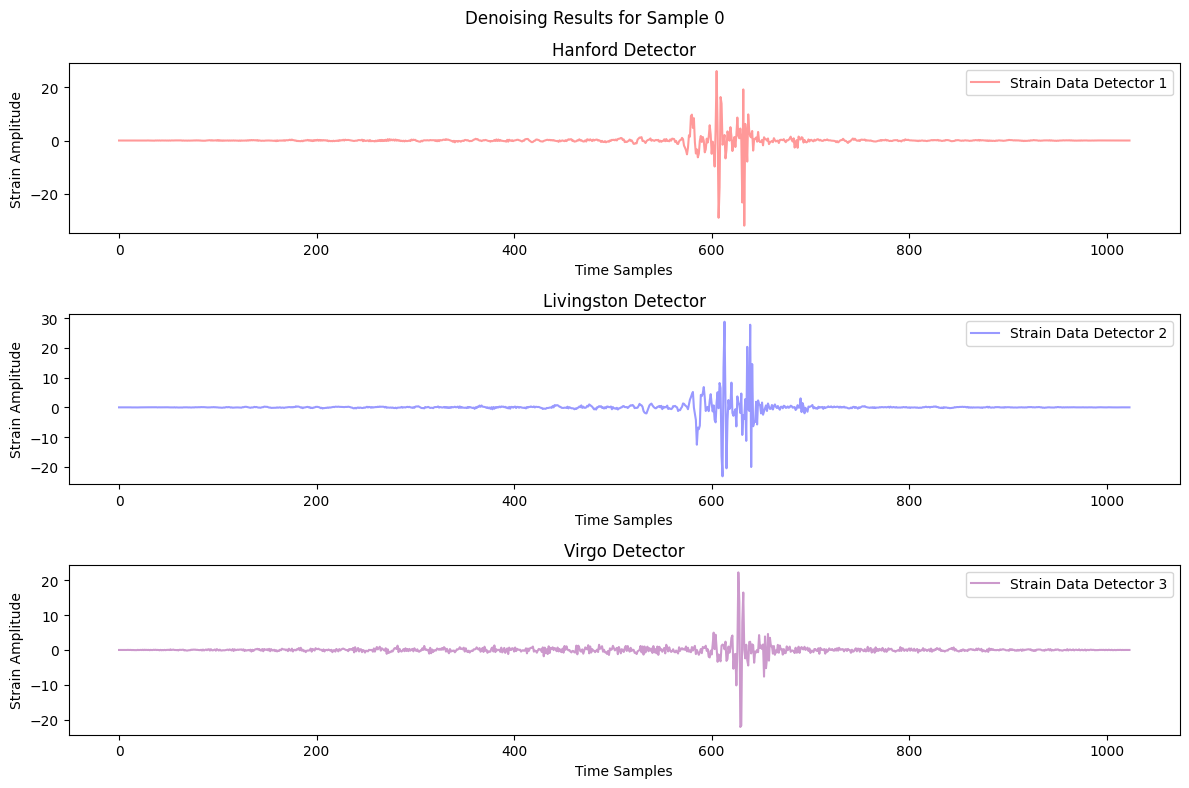

In [3]:
time = np.linspace(0, 1024, 1024)

sample_idx = 0

fig, axs = plt.subplots(3, 1, figsize=(12, 8))
detectors = ['Hanford', 'Livingston', 'Virgo']
col = ["red", "blue", "purple"]
for d in range(3):
    # Window the data to denoise a bit
    window = np.bartlett(data[sample_idx][d].size)
    x_windowed = data[sample_idx][d]*window
    axs[d].plot(x_windowed, color = f"{col[d]}", label=f'Strain Data Detector {d+1}', alpha=0.4)
    axs[d].legend()
    axs[d].set_title(f'{detectors[d]} Detector')
    axs[d].set_xlabel("Time Samples")
    axs[d].set_ylabel("Strain Amplitude")

print(params[sample_idx][0])
print(params[sample_idx][1])
print(params[sample_idx][2])
print(params[sample_idx][3])
print(params[sample_idx][4])
plt.suptitle(f"Denoising Results for Sample {sample_idx}")
plt.tight_layout()
plt.show()

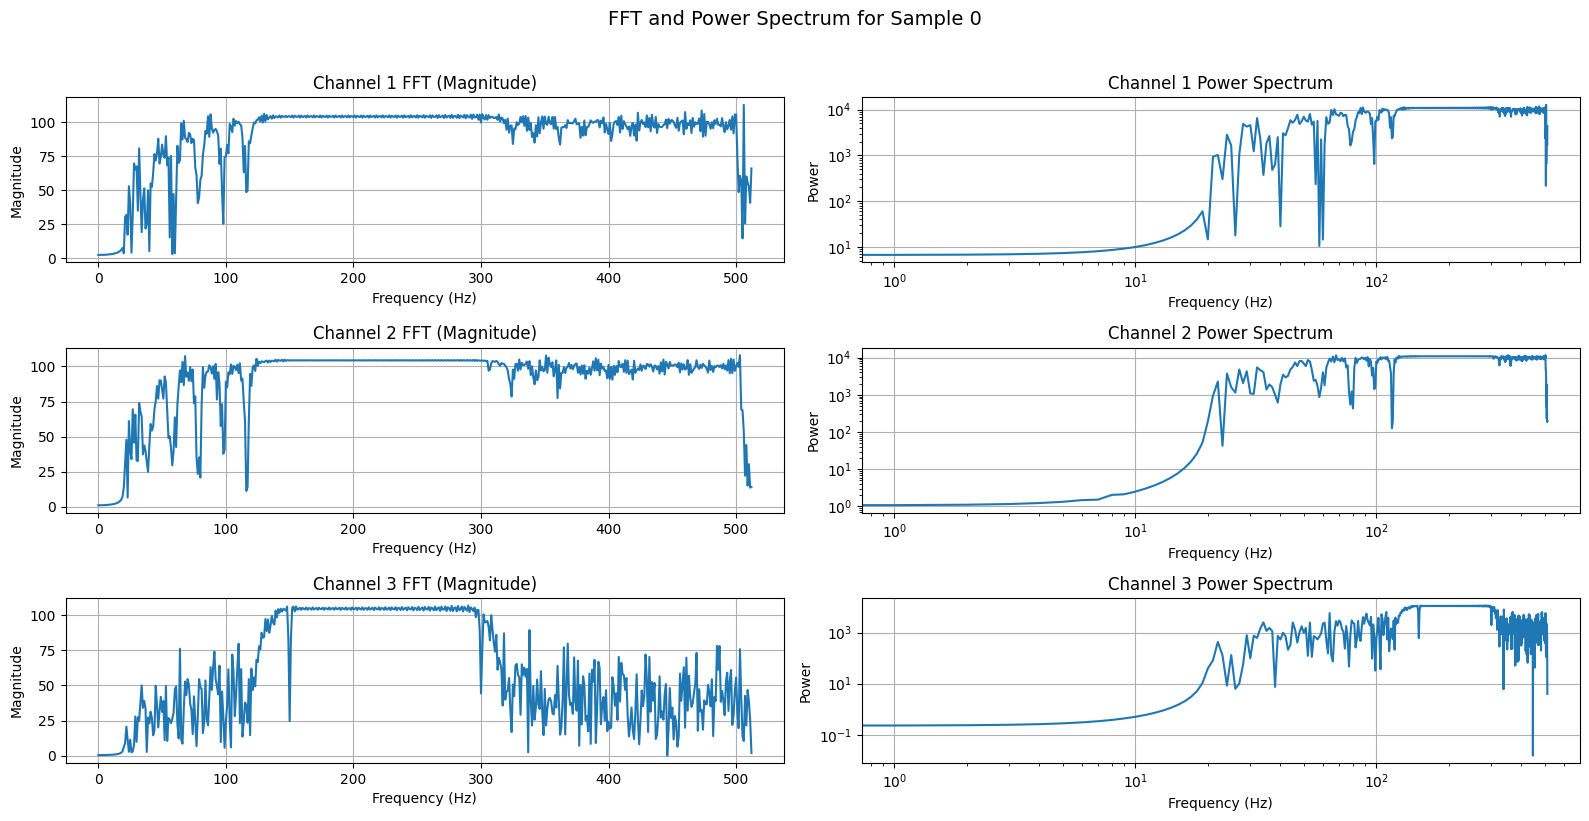

In [4]:
# Function to compute and plot FFT and power spectrum for a given sample index
def plot_fft_and_power_spectrum(data, sample_index=0):
    sample = data[sample_index]

    # Create frequency axis
    num_steps = sample.shape[1]
    sampling_rate = 1024
    frequencies = np.fft.rfftfreq(num_steps, d=1./sampling_rate)

    fig, axes = plt.subplots(3, 2, figsize=(16, 8))
    fig.suptitle(f"FFT and Power Spectrum for Sample {sample_index}", fontsize=14, y=1.02)

    # Iterate through each channel and compute FFT
    for i in range(3):
        channel_data = sample[i]

        # Compute FFT and power spectrum
        fft_values = np.fft.rfft(channel_data)
        power_spectrum = np.abs(fft_values) ** 2

        # Plot FFT (magnitude)
        axes[i, 0].plot(frequencies, np.abs(fft_values))
        axes[i, 0].set_title(f"Channel {i + 1} FFT (Magnitude)")
        axes[i, 0].set_xlabel("Frequency (Hz)")
        axes[i, 0].set_ylabel("Magnitude")
        axes[i, 0].grid(True)

        # Plot Power Spectrum
        axes[i, 1].loglog(frequencies, power_spectrum)
        axes[i, 1].set_title(f"Channel {i + 1} Power Spectrum")
        axes[i, 1].set_xlabel("Frequency (Hz)")
        axes[i, 1].set_ylabel("Power")
        axes[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_fft_and_power_spectrum(data, sample_index=0)

There are 4 different models at the moment:

- CNN with standard transformer encoder block.It uses a standard transformer design that combines several important components: multi-head self-attention, shortcuts between layers, and a feed-forward network. With multiple attention heads, the model can recognize different kinds of relationships and patterns in the features it gets from the CNN at the same time. The shortcuts and layer adjustments help make the training smoother, making sure the original CNN features and the new attention-based features work well together.

- CNN with positional encoding. The regular transformer block includes specific information about the position of the input data. Because self-attention methods don't automatically recognize the order of the data, adding positional information helps keep the sequence intact.

- CNN with a simplified, single head attention block. This makes transformer block simpler by using just one attention head, but it increases the size of the key to ensure the model can still understand important details. Fewer attention heads mean the model is less complicated and has fewer parts, which is helpful when there's not a lot of training data or when we want to avoid overfitting.

- And a standard ResNET model to compare against. In many survey papers, ResNET models have been found to be the best for time series analysis.

UPDATE:

Now the models are

- Standard CNN for a baseline

- Ensemble model of a CNN

- Ensemble model of a CNN + Single head attention block as it was the most performant

- ResNET50 Deep CNN

The models also take in correlation data between the detectors (Pearsons).

# Create transformer functions

In [5]:
def build_transformer_input(x_weighted, units=256, max_seq_len=1024):
    # Project weighted features to desired dimension.
    x_projected = layers.Dense(units, activation='relu')(x_weighted)

    # Try to get the static sequence length from x_projected.
    static_shape = tf.keras.backend.int_shape(x_projected)
    seq_len = static_shape[1] if static_shape[1] is not None else max_seq_len

    # Create positional indices for positions 0 to seq_len-1.
    positions = tf.range(start=0, limit=seq_len, delta=1)

    # Create a learnable Embedding layer with fixed max_seq_len.
    pos_embedding_layer = layers.Embedding(input_dim=max_seq_len, output_dim=units)

    # Get positional embeddings and slice out the first seq_len positions.
    pos_embeddings = pos_embedding_layer(positions)  # shape: (seq_len, units)
    pos_embeddings = tf.expand_dims(pos_embeddings, axis=0)  # shape: (1, seq_len, units)

    # Add positional embeddings to the projected features.
    transformer_input = x_projected + pos_embeddings
    return transformer_input


# Transformer Block
def transformer_block(x, key_dim=256, ff_dim=256, dropout_rate=0.1):
    x_norm = layers.LayerNormalization()(x)

    attn_output = layers.MultiHeadAttention(num_heads=2, key_dim=key_dim, dropout=dropout_rate)(x_norm, x_norm)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    x = layers.Add()([x_norm, attn_output])  # Residual connection

    x_norm = layers.LayerNormalization()(x)
    ffn_output = layers.Dense(ff_dim, activation='relu')(x_norm)
    ffn_output = layers.Dense(x.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    x = layers.Add()([x, ffn_output])
    return x

# Weighted Loss Function
def weighted_mse(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Compute the squared errors
        error = tf.square(y_true - y_pred)

        # Multiply each error by its corresponding weight
        weighted_error = error * weights

        # Return the mean over all outputs and samples
        return tf.reduce_mean(weighted_error)

    return loss

# Create individual losses

In [6]:
# Define loss functions for each output (using MSE here)
losses = {
    'param1': 'mse', # Central time
    'param2': 'mse', # Central Frequency
    'param3': 'mse', # Bandwidth
    'param4': 'mse', # Duration
    'param5': 'mse'  # SNR
}

# Define loss weights for each output
loss_weights = {
    'param1': 1.0,
    'param2': 1.0,
    'param3': 1.0,
    'param4': 1.0,
    'param5': 1.0
}

# Data preprocessing

In [7]:
# Data preprocessing
# Transpose X to match Keras Conv1D expected input shape: (samples, time steps, channels)
X = np.transpose(data, (0, 2, 1))

# Perform a 70-30 split for training and temporary set
X_train, X_temp, y_train, y_temp, corr_train, corr_temp = train_test_split(
    X, params, corr_stats, test_size=0.3, random_state=42
)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test, corr_val, corr_test = train_test_split(
    X_temp, y_temp, corr_temp, test_size=1/3, random_state=42
)

def split_by_last_param(data, params, corr, num_splits=3):
    # Ensure the number of entries match
    assert data.shape[0] == params.shape[0], "The number of entries in data and params must match."

    # Get the indices that would sort the params array by the last column
    sort_idx = np.argsort(params[:, -1])

    # Sort both arrays using these indices
    data_sorted = data[sort_idx]
    params_sorted = params[sort_idx]
    corr_sorted = corr_stats[sort_idx]

    # Split the sorted arrays into the desired number of segments
    data_splits = np.array_split(data_sorted, num_splits)
    params_splits = np.array_split(params_sorted, num_splits)
    corr_splits = np.array_split(corr_sorted, num_splits)

    return data_splits, params_splits, corr_splits

# Scale the target parameters
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled   = scaler.transform(y_val)
y_test_scaled  = scaler.transform(y_test)

data_splits, y_train_split, corr_splits = split_by_last_param(X_train, y_train_scaled, corr_stats)

# Baseline CNN

In [ ]:
# Baseline raw CNN used as a baseline

# Branch 1: Gravitational Wave Data (shape: (1024, 3))
wave_input = keras.Input(shape=(1024, 3), name='wave_input')

# CNN Front-End
x = layers.Conv1D(36, kernel_size=7, activation='relu')(wave_input)

# ResNet Block 1
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 2
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# ResNet Block 3
residual = x
x = layers.Conv1D(42, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1D(36, kernel_size=3, padding='same')(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.BatchNormalization()(x)

# Class Activation Map (CAM) preserving the temporal dimension
cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
x_weighted = layers.Multiply()([x, cam_output])
x_pooled = layers.GlobalAveragePooling1D()(x_weighted)

# Fully Connected Layers for the waveform branch
x_fc = layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-4))(x_pooled)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-4))(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)
x_fc = layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-4))(x_fc)
x_fc = layers.Dropout(0.5)(x_fc)

# Branch 2: Correlation Statistics (shape: (3,))
corr_input = keras.Input(shape=(3,), name='corr_input')
y = layers.Flatten()(corr_input)
y = layers.Dense(16, activation='relu')(corr_input)
y = layers.Dense(16, activation='relu')(y)

# Merge the two branches
merged = layers.Concatenate()([x_fc, y])
z = layers.Dense(32, activation='relu')(merged)

# 5 Separate Outputs for Regression
output1 = layers.Dense(1, activation='linear', name='param1')(z)
output2 = layers.Dense(1, activation='linear', name='param2')(z)
output3 = layers.Dense(1, activation='linear', name='param3')(z)
output4 = layers.Dense(1, activation='linear', name='param4')(z)
output5 = layers.Dense(1, activation='linear', name='param5')(z)

# Define the model using the two inputs
model_v1 = keras.Model(inputs=[wave_input, corr_input],
                       outputs=[output1, output2, output3, output4, output5])

# Compile the Model
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model_v1.compile(
    optimizer=optimizer,
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        'param1': ['mae', 'R2Score'],
        'param2': ['mae', 'R2Score'],
        'param3': ['mae', 'R2Score'],
        'param4': ['mae', 'R2Score'],
        'param5': ['mae', 'R2Score']
    }
)

# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
lr_reducer = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

# Fit the Model
for i in range(3):
    history_model_v1 = model_v1.fit(
        [data_splits[i], corr_splits[i]],
        {
            'param1': y_train_split[i][:, 0],
            'param2': y_train_split[i][:, 1],
            'param3': y_train_split[i][:, 2],
            'param4': y_train_split[i][:, 3],
            'param5': y_train_split[i][:, 4]
        },
        validation_data=(
            [X_val, corr_val],
            {
                'param1': y_val_scaled[:, 0],
                'param2': y_val_scaled[:, 1],
                'param3': y_val_scaled[:, 2],
                'param4': y_val_scaled[:, 3],
                'param5': y_val_scaled[:, 4]
            }
        ),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping_cb, lr_reducer]
    )

# Evaluate the Model
results = model_v1.evaluate(
    [X_test, corr_test],
    {
        'param1': y_test_scaled[:, 0],
        'param2': y_test_scaled[:, 1],
        'param3': y_test_scaled[:, 2],
        'param4': y_test_scaled[:, 3],
        'param5': y_test_scaled[:, 4]
    }
)

total_loss = results[0]
test_mae = results[1]
test_r2score = results[2]

print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2 Score: {test_r2score:.4f}")
print(f"Total Loss: {total_loss:.4f}")

model_v1.save("baseline_model.keras")

# CNN with transformer

In [ ]:
!pip install keras-tuner
import keras_tuner as kt

def build_model_transformer_tuner(hp):
    # ---- Waveform Branch ----
    wave_input = keras.Input(shape=(1024, 3), name="wave_input")
    conv_filters = hp.Int("conv_filters", min_value=32, max_value=64, step=4, default=36)
    kernel_size = hp.Choice("kernel_size", values=[5, 7, 9], default=7)
    x = layers.Conv1D(conv_filters, kernel_size=kernel_size, activation='relu')(wave_input)

    # ResNet Block 1
    residual = x
    conv1_units = hp.Int("conv1_units", min_value=32, max_value=64, step=4, default=42)
    x = layers.Conv1D(conv1_units, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 2
    residual = x
    x = layers.Conv1D(conv1_units, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # ResNet Block 3
    residual = x
    x = layers.Conv1D(conv1_units, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # Class Activation Map (CAM)
    cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
    x_weighted = layers.Multiply()([x, cam_output])

    # Project features for transformer input.
    transformer_units = hp.Int("transformer_units", min_value=128, max_value=256, step=64, default=256)
    # Assumes build_transformer_input is defined elsewhere.
    x_transformer_input = build_transformer_input(x_weighted, units=transformer_units)

    # Apply a simplified transformer block.
    key_dim = hp.Int("key_dim", min_value=128, max_value=256, step=64, default=256)
    ff_dim = hp.Int("ff_dim", min_value=128, max_value=256, step=64, default=256)
    dropout_transformer = hp.Float("dropout_transformer", min_value=0.1, max_value=0.3, step=0.1, default=0.1)

    x_transformer = transformer_block(x_transformer_input, key_dim=key_dim, ff_dim=ff_dim, dropout_rate=dropout_transformer)
    x_pooled = layers.GlobalAveragePooling1D()(x_transformer)

    # Correlation Branch
    corr_input = keras.Input(shape=(3, 1), name="corr_input")
    y = layers.Flatten()(corr_input)
    corr_units = hp.Int("corr_units", min_value=16, max_value=32, step=4, default=16)
    y = layers.Dense(corr_units, activation='relu')(y)
    y = layers.Dense(corr_units, activation='relu')(y)

    # Merge both branches.
    merged = layers.Concatenate()([x_pooled, y])

    # Output Heads for 5 Parameters
    outputs = []
    for i in range(5):
        z = layers.Dense(
            hp.Int(f"dense1_units_param_{i}", min_value=128, max_value=256, step=64, default=256),
            activation='relu'
        )(merged)
        dropout_rate = hp.Float(f"dropout_rate_param_{i}", min_value=0.5, max_value=0.8, step=0.1, default=0.7)
        z = layers.Dropout(dropout_rate)(z)
        z = layers.Dense(
            hp.Int(f"dense2_units_param_{i}", min_value=64, max_value=128, step=32, default=128),
            activation='relu'
        )(z)
        z = layers.Dropout(dropout_rate)(z)
        out = layers.Dense(1, activation='linear', name=f'param{i+1}')(z)
        outputs.append(out)

    model = keras.Model(inputs=[wave_input, corr_input], outputs=outputs)

    # Choose loss function as a hyperparameter.
    loss_choice = hp.Choice("loss_function", values=["mse", "huber", "logcosh"], default="mse")
    if loss_choice == "mse":
        loss = keras.losses.MeanSquaredError()
    elif loss_choice == "huber":
        delta = hp.Float("huber_delta", min_value=1.0, max_value=5.0, step=1.0, default=1.0)
        loss = keras.losses.Huber(delta=delta)
    elif loss_choice == "logcosh":
        loss = keras.losses.LogCosh()

    # Tune the learning rate.
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4], default=1e-3)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model with a loss and metrics for each output.
    losses = {f'param{i+1}': 'mse' for i in range(5)}
    metrics = {f'param{i+1}': ['mae', 'R2Score'] for i in range(5)}
    model.compile(optimizer=opt, loss=losses, metrics=metrics)

    return model

# Create a tuner using RandomSearch.
tuner = kt.RandomSearch(
    build_model_transformer_tuner,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory="optimus_tuning",
    project_name="transformer_ensemble"
)

y_train_list = [y_train_scaled[:, i].reshape(-1, 1) for i in range(5)]

tuner.search(
    [X_train, corr_train],
    y_train_list,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)

k = 5
fold_scores_transformer_tuned = []
fold_histories_transformer_tuned = []

# Retrieve the best model.
optimus_tuned = tuner.get_best_models(num_models=1)[0]

# Loop over each of the three splits.
for split_idx in range(len(data_splits)):
    print(f"\nProcessing split {split_idx+1} of {len(data_splits)}")

    # Get the split-specific data.
    X_split = data_splits[split_idx]
    y_split = y_train_split[split_idx]
    corr_split = corr_splits[split_idx]

    # Define the k-fold splitter.
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold = 1

    for train_index, val_index in kf.split(X_split):
        print(f"\nTraining fold {fold} on split {split_idx+1}...")

        # Split waveform and correlation data for this fold.
        X_tr_wave, X_val_wave = X_split[train_index], X_split[val_index]
        X_tr_corr, X_val_corr = corr_split[train_index], corr_split[val_index]

        # Split the target parameters.
        y_tr = y_split[train_index]
        y_val = y_split[val_index]
        y_tr_list = [y_tr[:, i].reshape(-1, 1) for i in range(5)]
        y_val_list = [y_val[:, i].reshape(-1, 1) for i in range(5)]

        # Build the model using the best hyperparameters from your tuner.
        model_fold = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials=1)[0])

        early_stopping_cb = keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )

        history = model_fold.fit(
            [X_tr_wave, X_tr_corr], y_tr_list,
            validation_data=([X_val_wave, X_val_corr], y_val_list),
            epochs=100,
            batch_size=64,
            callbacks=[early_stopping_cb],
            verbose=1
        )

        fold_histories_transformer_tuned.append(history)
        score = model_fold.evaluate([X_val_wave, X_val_corr], y_val_list, verbose=0)
        print(f"Fold {fold} evaluation score on split {split_idx+1}: {score}")
        fold_scores_transformer_tuned.append(score)
        fold += 1

# Compute the average score over all folds and splits.
avg_score = np.mean(fold_scores_transformer_tuned, axis=0)
print(f"\nAverage validation score (overall loss and per-output metrics): {avg_score}")

# Save the best overall model.
optimus_tuned.save("ensemble_model_transformer_optimus.keras")

# CNN without transformer

In [ ]:
def build_model_cnn_tuner(hp):
    # --- Waveform Branch ---
    wave_input = keras.Input(shape=(1024, 3), name="wave_input")

    # Tune initial convolution filters and kernel size.
    conv_filters = hp.Int("conv_filters", min_value=32, max_value=64, step=4, default=36)
    kernel_size = hp.Choice("kernel_size", values=[5, 7, 9], default=7)
    x = layers.Conv1D(conv_filters, kernel_size=kernel_size, activation='relu')(wave_input)

    # --- ResNet Block 1 ---
    residual = x
    res1_filters = hp.Int("res1_filters", min_value=32, max_value=64, step=4, default=42)
    x = layers.Conv1D(res1_filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # --- ResNet Block 2 ---
    residual = x
    x = layers.Conv1D(res1_filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # --- ResNet Block 3 ---
    residual = x
    x = layers.Conv1D(res1_filters, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv1D(conv_filters, kernel_size=3, padding='same')(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # --- Class Activation Map (CAM) ---
    cam_output = layers.Conv1D(1, kernel_size=1, activation='sigmoid', name='cam_layer')(x)
    x_weighted = layers.Multiply()([x, cam_output])
    x_pooled = layers.GlobalAveragePooling1D()(x_weighted)

    # --- Correlation Statistics Branch ---
    corr_input = keras.Input(shape=(3, 1), name="corr_input")
    y = layers.Flatten()(corr_input)
    # Optionally, you can also tune the number of units here.
    y = layers.Dense(16, activation='relu')(y)
    y = layers.Dense(16, activation='relu')(y)

    # --- Merge Branches ---
    merged = layers.Concatenate()([x_pooled, y])

    # --- Output Branches for 5 Parameters ---
    outputs = []
    # Tune the dense units and dropout rate for the output branches.
    dense1_units = hp.Int("dense1_units", min_value=128, max_value=256, step=32, default=256)
    dense2_units = hp.Int("dense2_units", min_value=64, max_value=128, step=32, default=128)
    dropout_rate = hp.Float("dropout_rate", min_value=0.5, max_value=0.8, step=0.1, default=0.7)

    for i in range(5):
        branch = layers.Dense(dense1_units, activation='relu')(merged)
        branch = layers.Dropout(dropout_rate)(branch)
        branch = layers.Dense(dense2_units, activation='relu')(branch)
        branch = layers.Dropout(dropout_rate)(branch)
        out = layers.Dense(1, activation='linear', name=f'param{i+1}')(branch)
        outputs.append(out)

    model = keras.Model(inputs=[wave_input, corr_input], outputs=outputs)

    # Choose loss function as a hyperparameter.
    loss_choice = hp.Choice("loss_function", values=["mse", "huber", "logcosh"], default="mse")
    if loss_choice == "mse":
        loss = keras.losses.MeanSquaredError()
    elif loss_choice == "huber":
        delta = hp.Float("huber_delta", min_value=1.0, max_value=5.0, step=1.0, default=1.0)
        loss = keras.losses.Huber(delta=delta)
    elif loss_choice == "logcosh":
        loss = keras.losses.LogCosh()

    # Tune the learning rate.
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4], default=1e-3)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model with a loss and metrics for each output.
    losses = {f'param{i+1}': 'mse' for i in range(5)}
    metrics = {f'param{i+1}': ['mae', 'R2Score'] for i in range(5)}
    model.compile(optimizer=opt, loss=losses, metrics=metrics)

    return model


tuner = kt.RandomSearch(
    build_model_cnn_tuner,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory="cnn_tuning",
    project_name="ensemble_cnn"
)


y_train_list = [y_train_scaled[:, i].reshape(-1, 1) for i in range(5)]

tuner.search(
    [X_train, corr_train],
    y_train_list,
    epochs=50,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
)

# Retrieve the best hyperparameters and model.
cnn_tuned = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

k = 5
fold_scores_tuned = []    # To record evaluation scores for each fold (for all outputs)
fold_histories_tuned = [] # To record training histories for each fold

# Loop over each split from the custom function.
for split_idx in range(len(data_splits)):
    print(f"\nProcessing split {split_idx+1} of {len(data_splits)}")

    # Get the data for the current split.
    X_split = data_splits[split_idx]
    y_split = y_train_split[split_idx]
    corr_split = corr_splits[split_idx]

    # Define the k-fold splitter for the current split.
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold = 1

    for train_index, val_index in kf.split(X_split):
        print(f"\nTraining fold {fold} on split {split_idx+1}...")
        # Split waveform and correlation data for this fold.
        X_tr_wave, X_val_wave = X_split[train_index], X_split[val_index]
        X_tr_corr, X_val_corr = corr_split[train_index], corr_split[val_index]

        # Split the target parameters.
        y_tr = y_split[train_index]
        y_val = y_split[val_index]
        y_tr_list = [y_tr[:, i].reshape(-1, 1) for i in range(5)]
        y_val_list = [y_val[:, i].reshape(-1, 1) for i in range(5)]

        # Build a fresh model using the best hyperparameters.
        model_fold = tuner.hypermodel.build(best_hp)

        early_stopping_cb = keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        )

        history = model_fold.fit(
            [X_tr_wave, X_tr_corr],
            y_tr_list,
            validation_data=([X_val_wave, X_val_corr], y_val_list),
            epochs=100,
            batch_size=64,
            callbacks=[early_stopping_cb],
            verbose=1
        )
        fold_histories_tuned.append(history)

        score = model_fold.evaluate([X_val_wave, X_val_corr], y_val_list, verbose=0)
        print(f"Fold {fold} evaluation score on split {split_idx+1}: {score}")
        fold_scores_tuned.append(score)
        fold += 1

avg_score = np.mean(fold_scores_tuned, axis=0)
print(f"\nAverage validation score (overall loss and per-output metrics): {avg_score}")

# Save the best overall model.
cnn_tuned.save("ensemble_model_v2_tuned.keras")

# Load models from saved files

In [8]:
import os
import json
from tensorflow.keras.models import model_from_json

def load_model_from_folder(folder_path):
    # Load metadata
    metadata_path = os.path.join(folder_path, 'metadata.json')
    with open(metadata_path, 'r') as meta_file:
        metadata = json.load(meta_file)

    # Load model configuration from config.json
    config_path = os.path.join(folder_path, 'config.json')
    with open(config_path, 'r') as config_file:
        # If the config is stored as a dictionary, convert it back to a JSON string.
        model_config = json.load(config_file)
    model_json = json.dumps(model_config)

    # Recreate the model from the JSON configuration
    model = model_from_json(model_json)

    # Load the weights from the HDF5 file
    weights_path = os.path.join(folder_path, 'model.weights.h5')
    model.load_weights(weights_path)

    return model

CNN = 'CNN/'
CNN_tuned = 'CNN_tuned/'
Transformer = 'Transformer/'
model_v1 = load_model_from_folder(CNN)
cnn_tuned = load_model_from_folder(CNN_tuned)
optimus_tuned = load_model_from_folder(Transformer)

2025-03-10 13:10:31.657841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-10 13:10:31.661227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-10 13:10:31.663426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Visualise random CAM data

2025-03-10 13:10:33.418420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


1/1 [==============================] - 1s 802ms/step


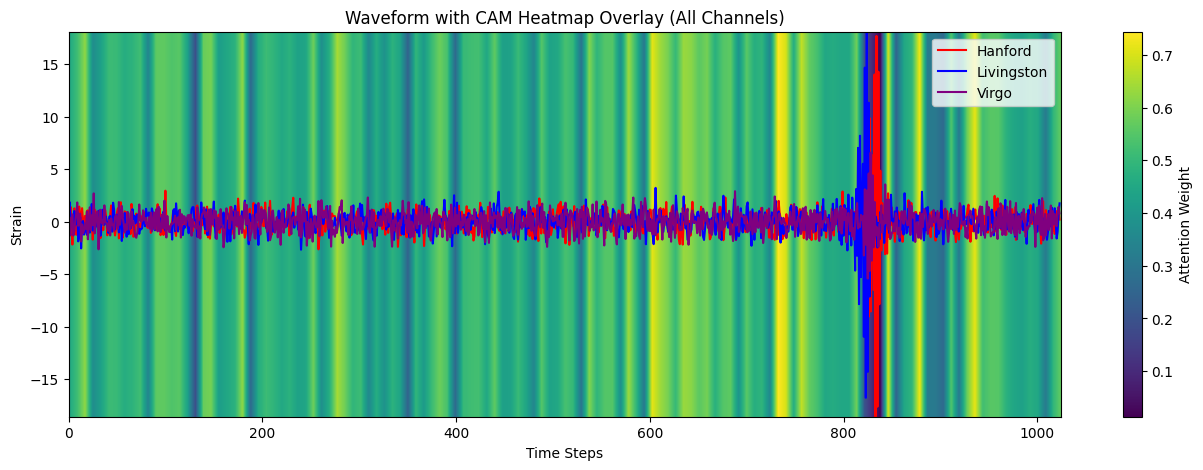

1/1 [==============================] - 0s 294ms/step


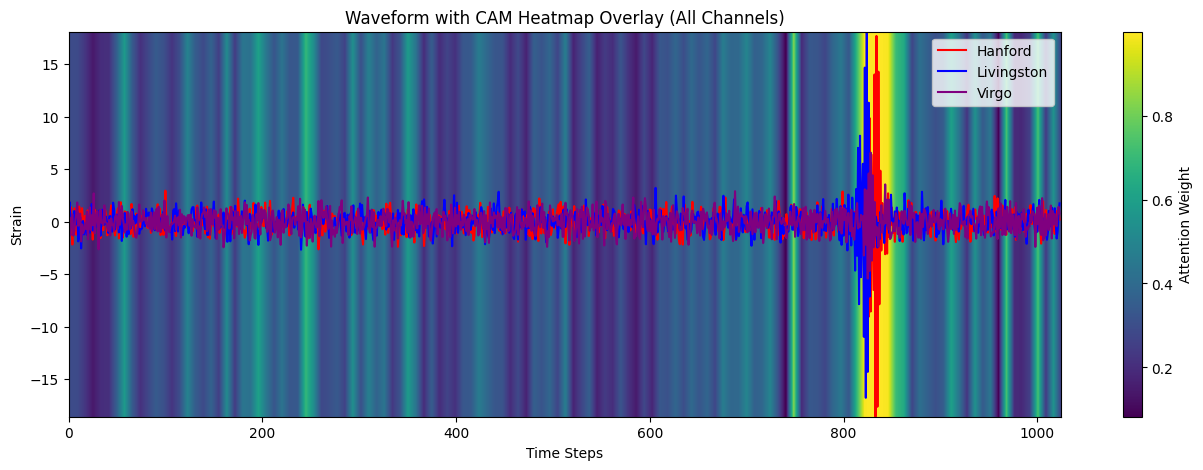

1/1 [==============================] - 0s 271ms/step


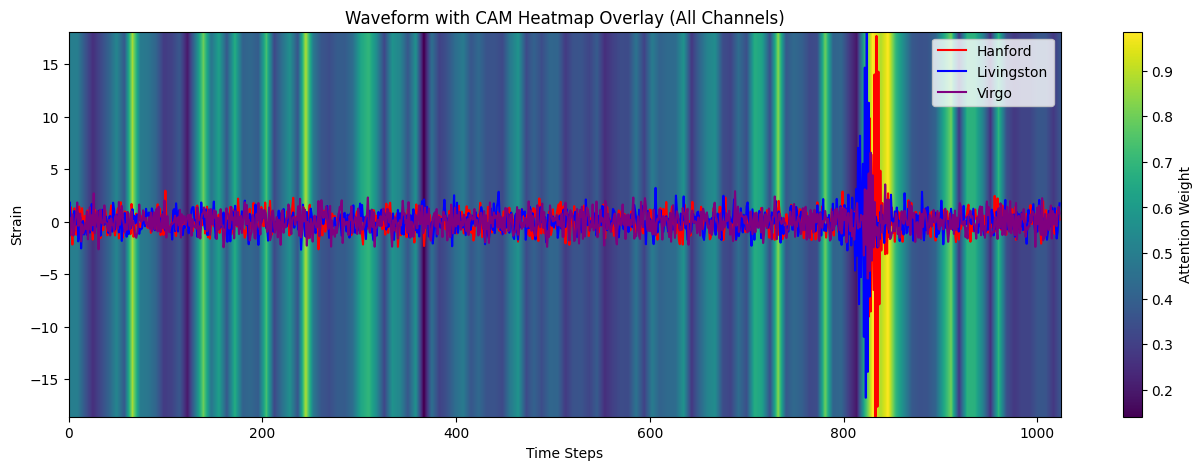

In [9]:
def visualize_cam_all_channels(sample_index, model):
    # Extract the waveform sample
    waveform_sample = X_test[sample_index]  # (1024, 3)

    # Determine overall min and max for y-axis across all channels
    y_min = waveform_sample.min()
    y_max = waveform_sample.max()

    # Build a model that outputs the CAM from the layer named 'cam_layer'
    cam_model = keras.Model(inputs=model.input, outputs=model.get_layer('cam_layer').output)

    # For a multi-input model, pass both inputs as a list. Here we assume corr_test is indexed similarly.
    cam_out = cam_model.predict([X_test[[sample_index]], corr_test[[sample_index]]])[0]
    cam_out = cam_out.squeeze()

    # Upsample the CAM to match the waveform length
    num_points = 1024
    x_old = np.linspace(0, num_points - 1, num=len(cam_out))
    x_new = np.arange(num_points)
    cam_upsampled = np.interp(x_new, x_old, cam_out)

    # Create a 2D heatmap array by replicating the upsampled CAM
    heatmap = np.tile(cam_upsampled, (10, 1))

    # Plot the waveform (all channels) and overlay the CAM heatmap
    fig, ax = plt.subplots(figsize=(16, 5))
    x = np.arange(num_points)
    ax.plot(x, waveform_sample[:, 0], label='Hanford', color='red')
    ax.plot(x, waveform_sample[:, 1], label='Livingston', color='blue')
    ax.plot(x, waveform_sample[:, 2], label='Virgo', color='purple')

    # Overlay the heatmap with imshow
    im = ax.imshow(heatmap, aspect='auto', cmap='viridis', alpha=1,
                   extent=[0, num_points, y_min, y_max],
                   origin='lower')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight')

    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Strain')
    ax.set_title('Waveform with CAM Heatmap Overlay (All Channels)')
    ax.legend()
    plt.show()

indexes = np.random.randint(0, 300, 1)
for i in indexes:
    visualize_cam_all_channels(sample_index=i, model=model_v1)
    visualize_cam_all_channels(sample_index=i, model=optimus_tuned)
    visualize_cam_all_channels(sample_index=i, model=cnn_tuned)

# Plot loss statistics from training

In [ ]:
def compute_total_stats(history, target_scaler):
    # Keys for training and validation metrics (assume each history entry is in normalized space)
    train_keys_mae = [f'param{i}_mae' for i in range(1, 6)]
    val_keys_mae   = [f'val_param{i}_mae' for i in range(1, 6)]
    train_keys_r2  = [f'param{i}_R2Score' for i in range(1, 6)]
    val_keys_r2    = [f'val_param{i}_R2Score' for i in range(1, 6)]

    # Determine minimum epochs for consistency.
    min_epochs = len(history['loss'])

    # Function to inverse-scale metric values.
    def inverse_metric(metric_values):
        metric_array = np.array(metric_values)
        scale_range = target_scaler.data_max_ - target_scaler.data_min_
        return metric_array * scale_range.mean()

    total_train_mae = np.mean([inverse_metric(history[k]) for k in train_keys_mae if k in history], axis=0)
    total_val_mae   = np.mean([inverse_metric(history[k]) for k in val_keys_mae if k in history], axis=0)

    # For R2Score, if key is missing, substitute zeros.
    def get_metric(hist, key):
        if key in hist:
            return np.array(hist[key])
        else:
            return np.zeros(min_epochs)

    total_train_r2 = np.mean([get_metric(history, k) for k in train_keys_r2], axis=0)
    total_val_r2   = np.mean([get_metric(history, k) for k in val_keys_r2], axis=0)

    return total_train_mae, total_val_mae, total_train_r2, total_val_r2

total_train_mae_v1, total_val_mae_v1, total_train_r2_v1, total_val_r2_v1 = compute_total_stats(history_model_v1.history, scaler)

def compute_ensemble_stats(ensemble_histories):
    # Determine the minimum number of epochs across all fold histories
    min_epochs = min(len(hist['loss']) for hist in ensemble_histories.values())

    # Initialize lists for overall loss (as lists, not dictionaries)
    train_loss_list, val_loss_list = [], []

    # Initialize dictionaries for MAE for each parameter.
    train_mae_dict = {f'param{i+1}': [] for i in range(5)}
    val_mae_dict   = {f'param{i+1}': [] for i in range(5)}

    for hist in ensemble_histories.values():
        # Overall loss (the total loss is recorded under 'loss')
        train_loss_list.append(np.array(hist['loss'][:min_epochs]))
        if 'val_loss' in hist:
            val_loss_list.append(np.array(hist['val_loss'][:min_epochs]))
        # For each output, collect the corresponding MAE metrics.
        for i in range(5):
            key = f'param{i+1}_mae'
            val_key = f'val_param{i+1}_mae'
            train_mae_dict[f'param{i+1}'].append(np.array(hist[key][:min_epochs]))
            val_mae_dict[f'param{i+1}'].append(np.array(hist[val_key][:min_epochs]))

    # Stack overall losses into arrays of shape (num_folds, min_epochs)
    train_loss_arr = np.stack(train_loss_list, axis=0)
    avg_train_loss = np.mean(train_loss_arr, axis=0)

    if val_loss_list:  # if validation losses are recorded
        val_loss_arr = np.stack(val_loss_list, axis=0)
        avg_val_loss = np.mean(val_loss_arr, axis=0)
    else:
        avg_val_loss = None

    # For each output, stack and average the MAE values over folds.
    avg_train_mae = {}
    avg_val_mae   = {}
    for i in range(5):
        param = f'param{i+1}'
        train_arr = np.stack(train_mae_dict[param], axis=0)
        avg_train_mae[param] = np.mean(train_arr, axis=0)
        val_arr = np.stack(val_mae_dict[param], axis=0)
        avg_val_mae[param] = np.mean(val_arr, axis=0)

    return avg_train_loss, avg_val_loss, avg_train_mae, avg_val_mae

ensemble_train_loss_tuned, ensemble_val_loss_tuned, ensemble_train_mae_tuned, ensemble_val_mae_tuned = compute_ensemble_stats(ensemble_histories_tuned)
ensemble_train_loss_t_tuned, ensemble_val_loss_t_tuned, ensemble_train_mae_t_tuned, ensemble_val_mae_t_tuned = compute_ensemble_stats(ensemble_histories_transformer_tuned)

# Plotting Graphs
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Loss Curve (Training vs Validation)
#axes[0].plot(ensemble_train_loss_t, label='Train Loss (Ensemble + Transformer)')
#axes[0].plot(ensemble_val_loss_t, label='Validation Loss (Ensemble + Transformer)')
axes[0].plot(ensemble_train_loss_tuned, label='Train Loss (Ensemble (Tuned))')
axes[0].plot(ensemble_val_loss_tuned, label='Validation Loss (Ensemble (Tuned))')
axes[0].plot(ensemble_train_loss_t_tuned, label='Train Loss (Ensemble + Transformer (Tuned))')
axes[0].plot(ensemble_val_loss_t_tuned, label='Validation Loss (Ensemble + Transformer (Tuned))')
axes[0].set_yscale('log')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend(loc=1, prop={'size': 6})
axes[0].grid(True)

# Mean Absolute Error Curve (Aggregate)
# For the ensemble, average MAE across outputs:
ensemble_train_mae_avg_tuned = np.mean([avg for avg in ensemble_train_mae_tuned.values()], axis=0)
ensemble_val_mae_avg_tuned = np.mean([avg for avg in ensemble_val_mae_tuned.values()], axis=0)
ensemble_train_mae_avg_t_tuned = np.mean([avg for avg in ensemble_train_mae_t_tuned.values()], axis=0)
ensemble_val_mae_avg_t_tuned = np.mean([avg for avg in ensemble_val_mae_t_tuned.values()], axis=0)
#axes[1].plot(total_train_mae_v1, label='Train MAE (Standard Encoder)')
#axes[1].plot(total_val_mae_v1, label='Validation MAE (Standard Encoder)')
axes[1].plot(ensemble_train_mae_avg_tuned, label='Train MAE (Ensemble (Tuned))')
axes[1].plot(ensemble_val_mae_avg_tuned, label='Validation MAE (Ensemble (Tuned))')
axes[1].plot(ensemble_train_mae_avg_t_tuned, label='Train MAE (Ensemble + Transfomer (Tuned))')
axes[1].plot(ensemble_val_mae_avg_t_tuned, label='Validation MAE (Ensemble + Transformer (Tuned))')
axes[1].set_yscale('log')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend(loc=1, prop={'size': 6})
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Plot residual distributions

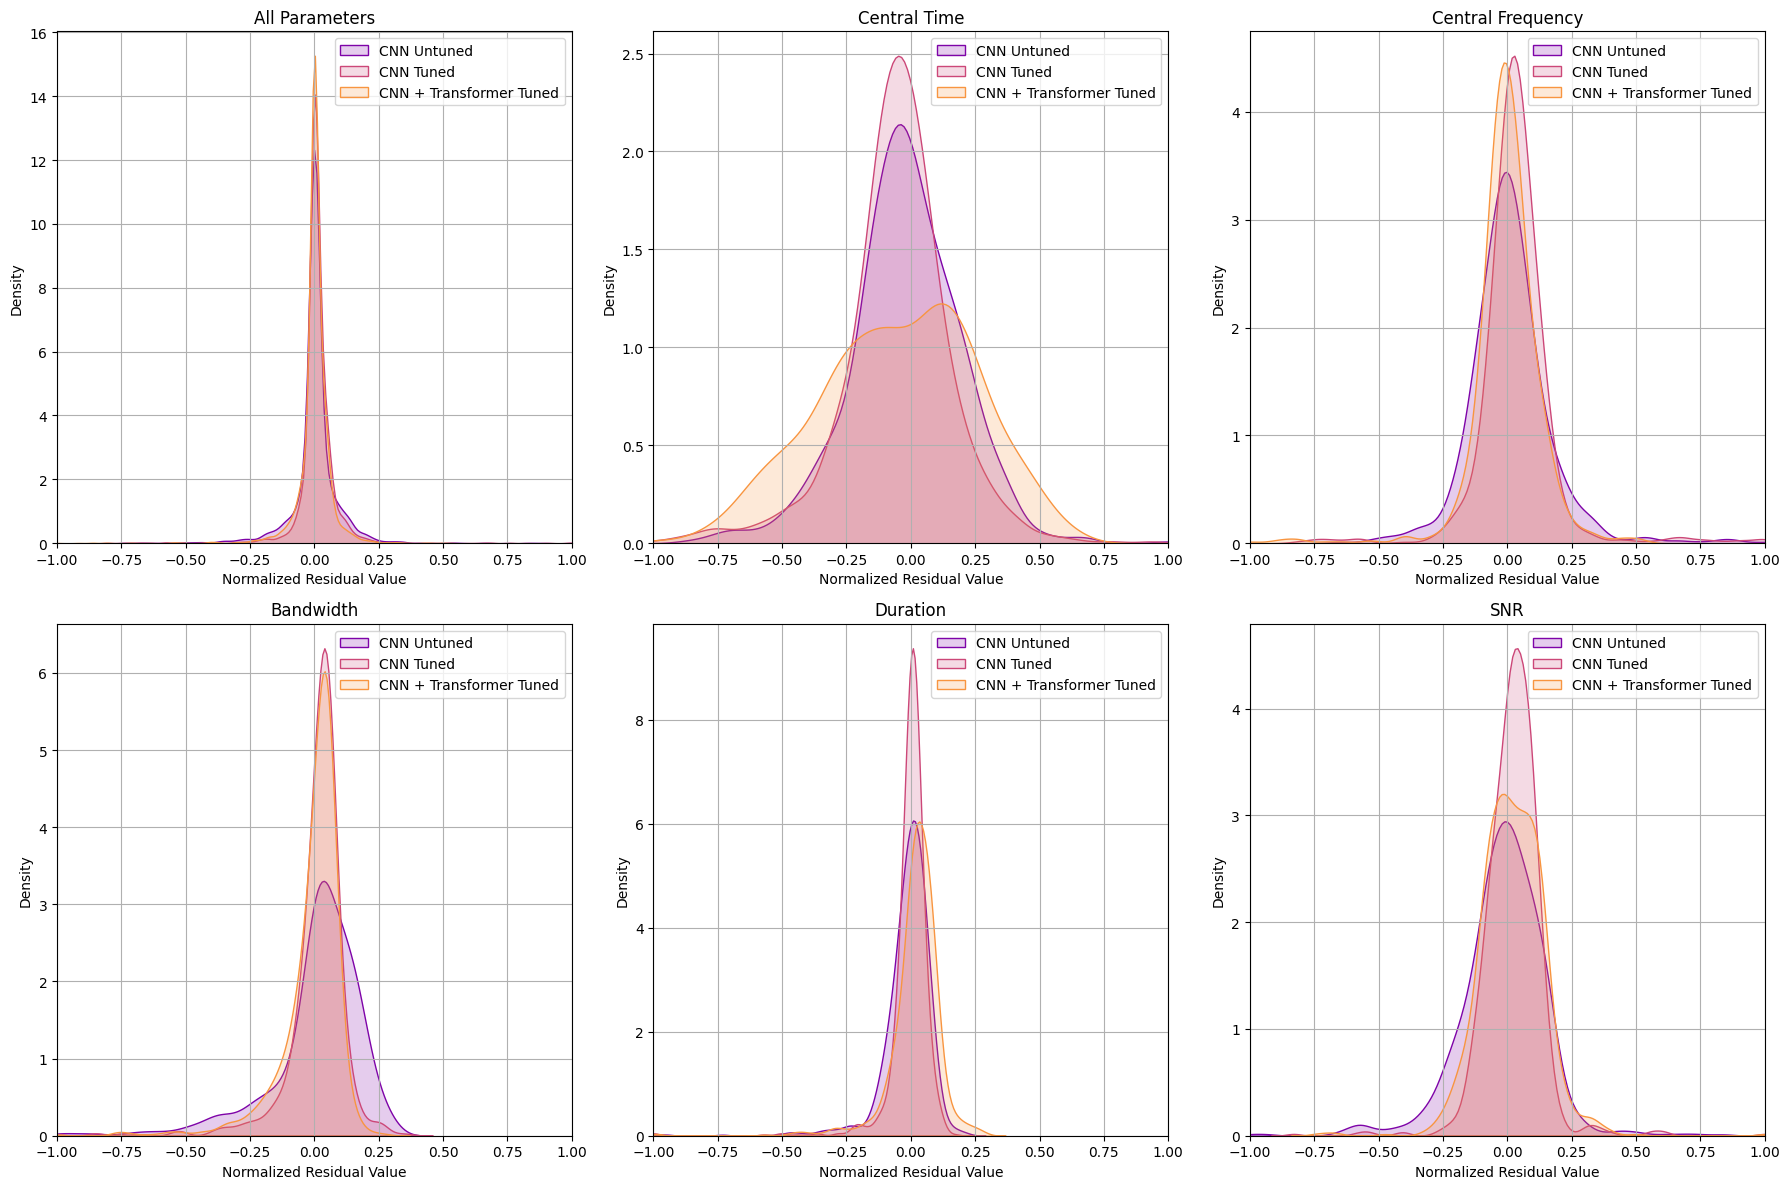


Confidence Intervals for CNN Untuned:
     Parameter      Mean        Std  3 sigma Lower  3 sigma Upper
0  Parameter 1 -0.016561   0.155756      -0.483829       0.450707
1  Parameter 2  2.640757  46.611966    -137.195141     142.476656
2  Parameter 3  1.325272  38.401041    -113.877851     116.528395
3  Parameter 4 -0.004113   0.029625      -0.092987       0.084761
4  Parameter 5 -1.385422  13.502392     -41.892598      39.121755

Confidence Intervals for CNN Tuned:
     Parameter      Mean        Std  3 sigma Lower  3 sigma Upper
0  Parameter 1 -0.031596   0.118170      -0.386107       0.322916
1  Parameter 2  8.298990  37.762177    -104.987540     121.585521
2  Parameter 3  1.736834  22.826140     -66.741587      70.215255
3  Parameter 4 -0.001616   0.023862      -0.073202       0.069970
4  Parameter 5  2.091177  10.540455     -29.530187      33.712541

Confidence Intervals for CNN + Transformer Tuned:
     Parameter      Mean        Std  3 sigma Lower  3 sigma Upper
0  Parameter 1 

In [10]:
import seaborn as sns

def predict_params_unscaled(model, sample, scaler):
    # Ensure the sample has a batch dimension from (1024, 3) to (1, 1024, 3)
    sample_batch = np.expand_dims(sample, axis=0)

    # Compute Pearson correlations
    stat1 = pg.corr(sample[:, 0], sample[:, 1])
    stat2 = pg.corr(sample[:, 0], sample[:, 2])
    stat3 = pg.corr(sample[:, 1], sample[:, 2])

    # Create the correlation stats input with a batch dimension
    corr_stats = np.array([[stat1.r, stat2.r, stat3.r]])

    # Predict using the model.
    y_pred_list = model.predict([sample_batch, corr_stats], verbose=0)

    # Convert the list of arrays to a 1D array of 5 values.
    y_pred_scaled = np.array([pred[0, 0] for pred in y_pred_list])

    y_pred_scaled = y_pred_scaled.reshape(1, -1)
    y_pred_original = scaler.inverse_transform(y_pred_scaled).flatten()

    return y_pred_original

def compute_residuals(models, X, y_true, scaler):
    residuals = [np.array([predict_params_unscaled(model, sample, scaler) for sample in X]) - y_true for model in models]
    return residuals

def plot_residual_distributions(residuals, model_labels, param_labels=None):
    num_params = residuals[0].shape[1]  # Number of target variables

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    colors = sns.color_palette("plasma", len(model_labels))

    # Plot distributions: first subplot is the combined plot.
    for i in range(num_params + 1):  # +1 for combined plot
        ax = axes[i]
        for res, label, color in zip(residuals, model_labels, colors):
            # Select data for the combined plot or for a specific parameter.
            data = res.flatten() if i == 0 else res[:, i-1]
            # Normalize the data to be between -1 and 1.
            data_normalized = normalize_to_range(data)
            sns.kdeplot(data_normalized, ax=ax, label=label, fill=True, alpha=0.2, color=color)

        ax.set_xlabel("Normalized Residual Value")
        ax.set_ylabel("Density")
        ax.set_title("All Parameters" if i == 0 else param_labels[i-1])
        ax.set_xlim(-1,1)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

def normalize_to_range(data):
    max_abs = np.max(np.abs(data))
    return data if max_abs == 0 else data / max_abs

# Function to compute confidence intervals for each parameter.
def compute_confidence_intervals(residuals, sigma_levels=[1, 2, 3], model_labels=None):
    results = {}
    num_params = residuals[0].shape[1]
    param_labels = [f'Parameter {i+1}' for i in range(num_params)]

    for i, res in enumerate(residuals):
        model_name = model_labels[i] if model_labels is not None else f'Model {i+1}'
        rows = []
        for j in range(num_params):
            param_data = res[:, j]
            mean = np.mean(param_data)
            std = np.std(param_data)
            intervals = {}
            for sigma in sigma_levels:
                lower = mean - sigma * std
                upper = mean + sigma * std
                intervals[f'{sigma} sigma Lower'] = lower
                intervals[f'{sigma} sigma Upper'] = upper
            row = {'Parameter': param_labels[j], 'Mean': mean, 'Std': std}
            row.update(intervals)
            rows.append(row)
        df = pd.DataFrame(rows)
        results[model_name] = df
    return results

models = [model_v1, cnn_tuned, optimus_tuned]
model_labels = ["CNN Untuned", "CNN Tuned", "CNN + Transformer Tuned"]
param_labels = ['Central Time', 'Central Frequency', 'Bandwidth', 'Duration', 'SNR']

# Compute residuals for each model.
residuals = compute_residuals(models, X_test, y_test, scaler)

# Plot the residual distributions.
plot_residual_distributions(residuals, model_labels, param_labels)

# Compute confidence intervals for each model.
ci_tables = compute_confidence_intervals(residuals, sigma_levels=[3], model_labels=model_labels)

for model_name, df in ci_tables.items():
    print(f"\nConfidence Intervals for {model_name}:")
    print(df)

# Visualise the top 5 and worst 5 waveforms from each model

1/1 [==============================] - 0s 102ms/step


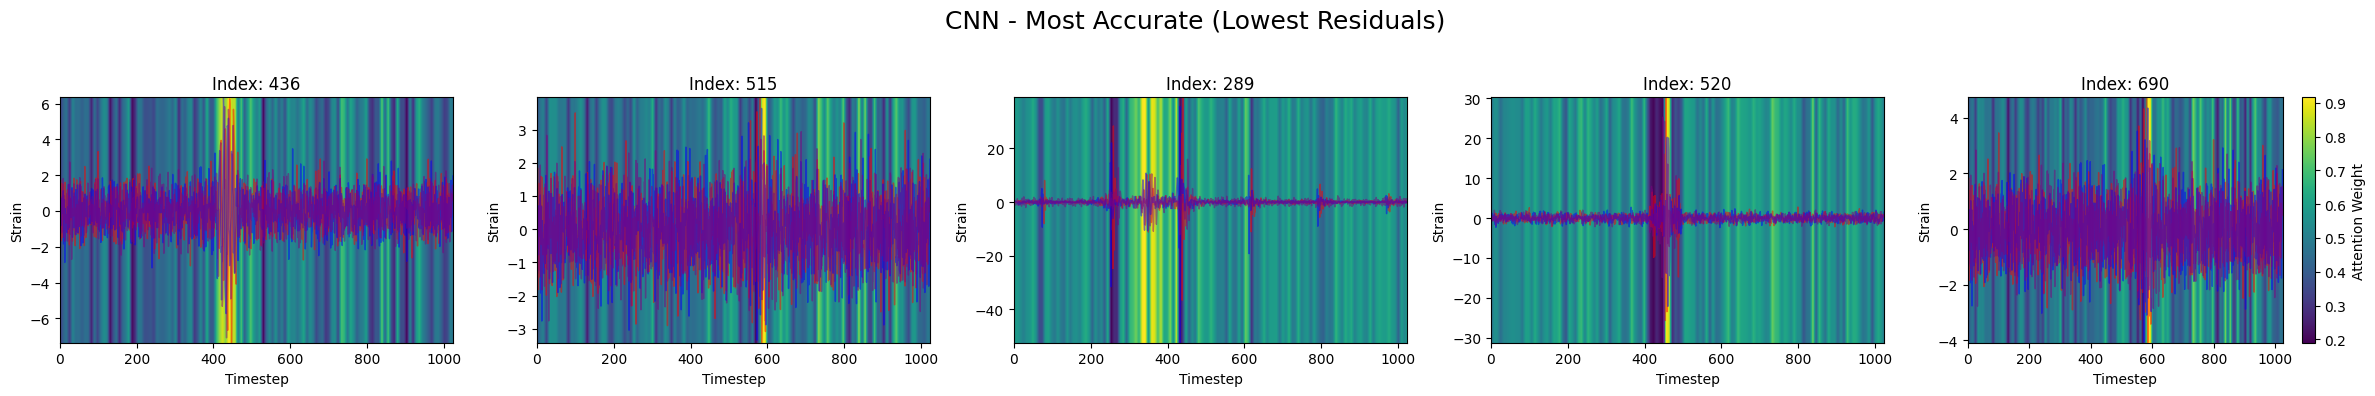

1/1 [==============================] - 0s 105ms/step


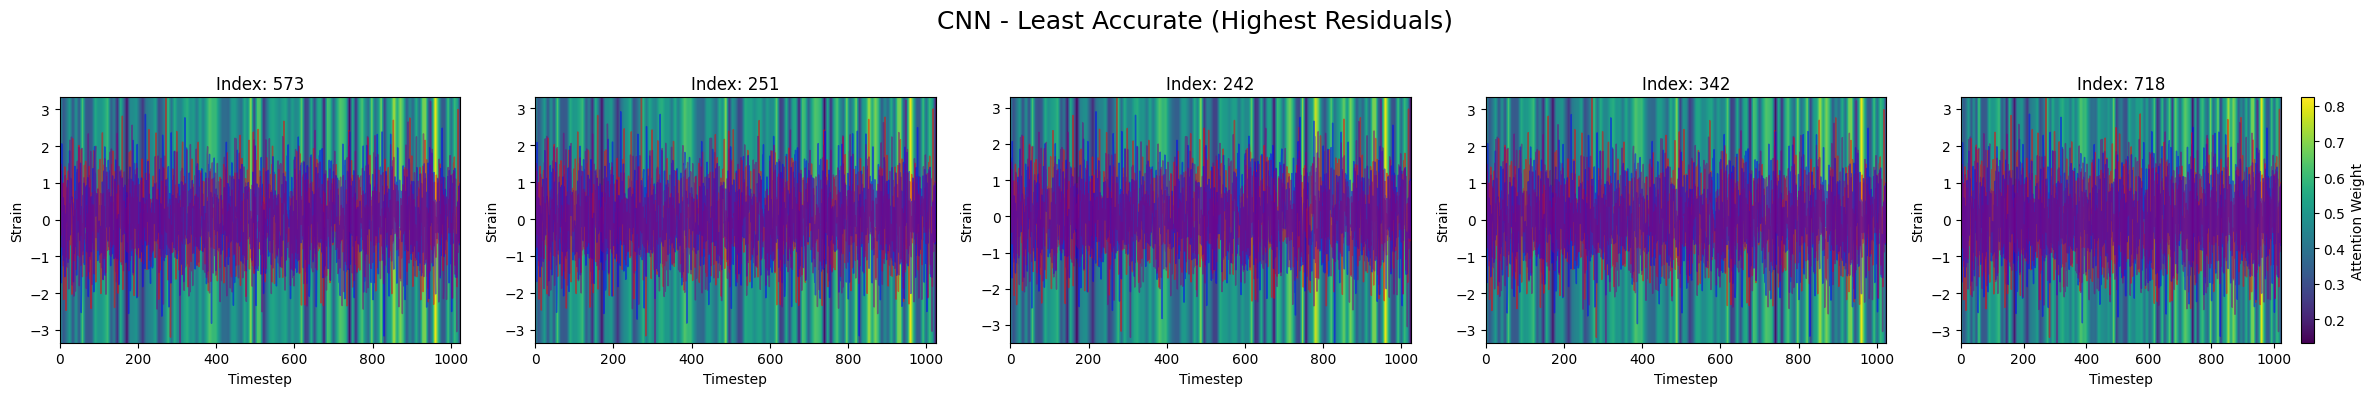

1/1 [==============================] - 0s 98ms/step


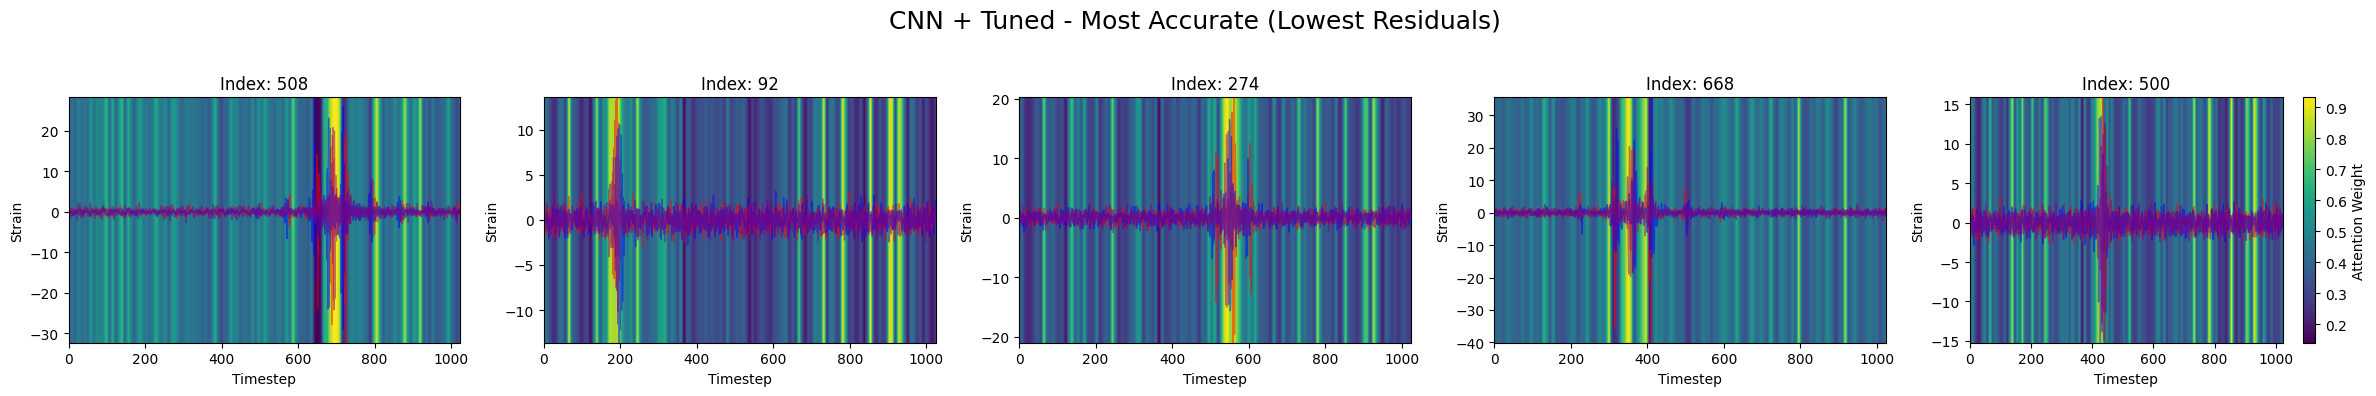

1/1 [==============================] - 0s 104ms/step


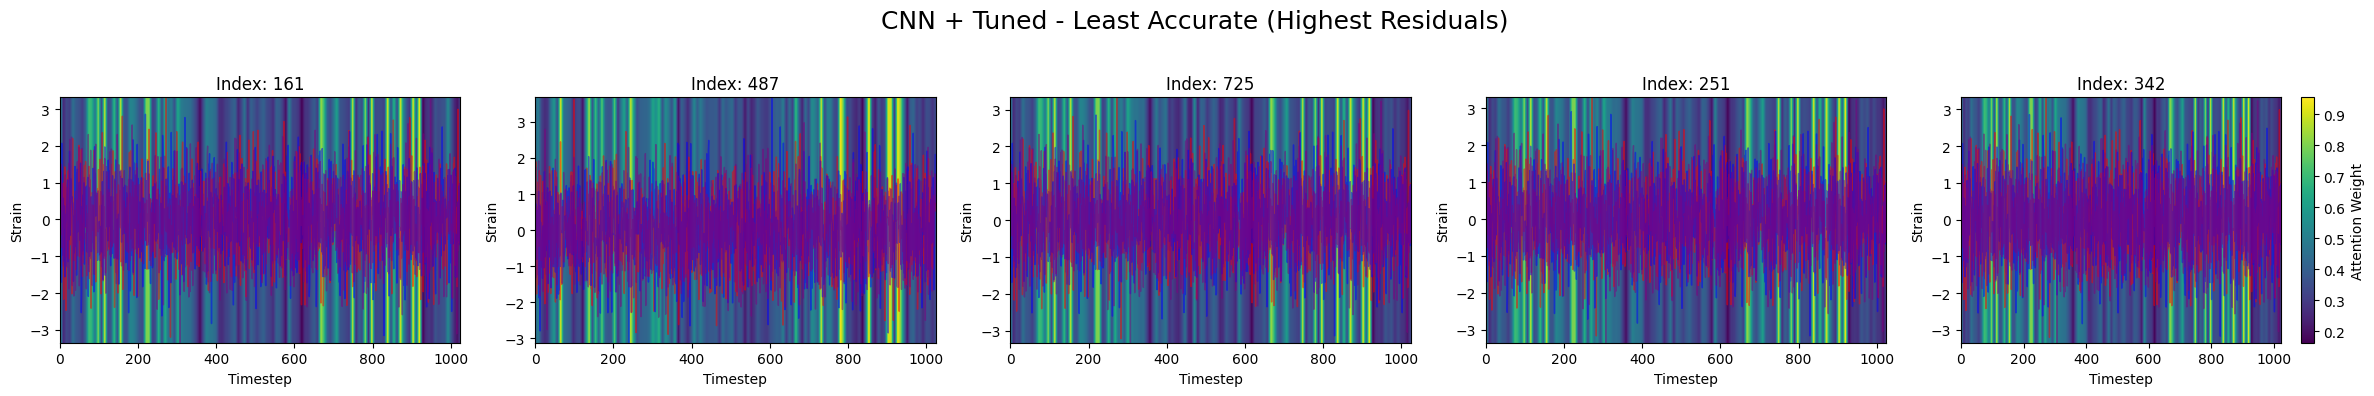

1/1 [==============================] - 0s 100ms/step


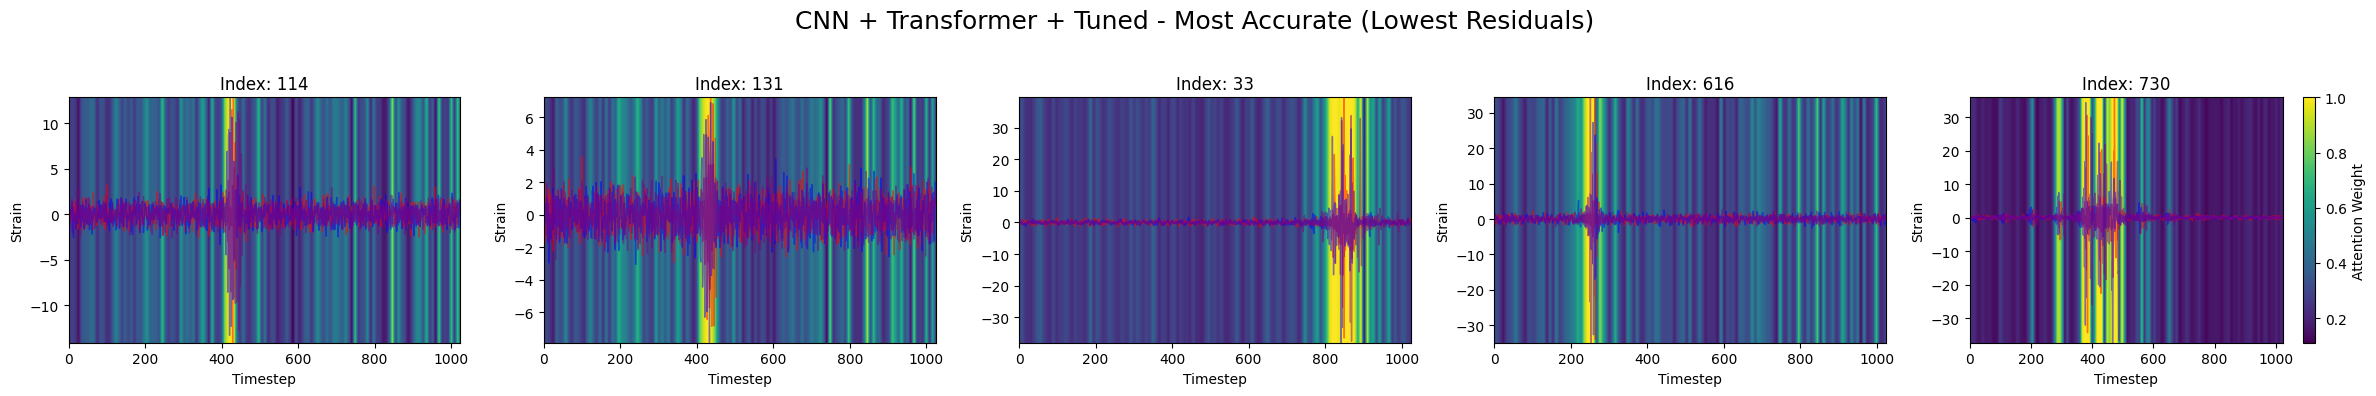

1/1 [==============================] - 0s 134ms/step


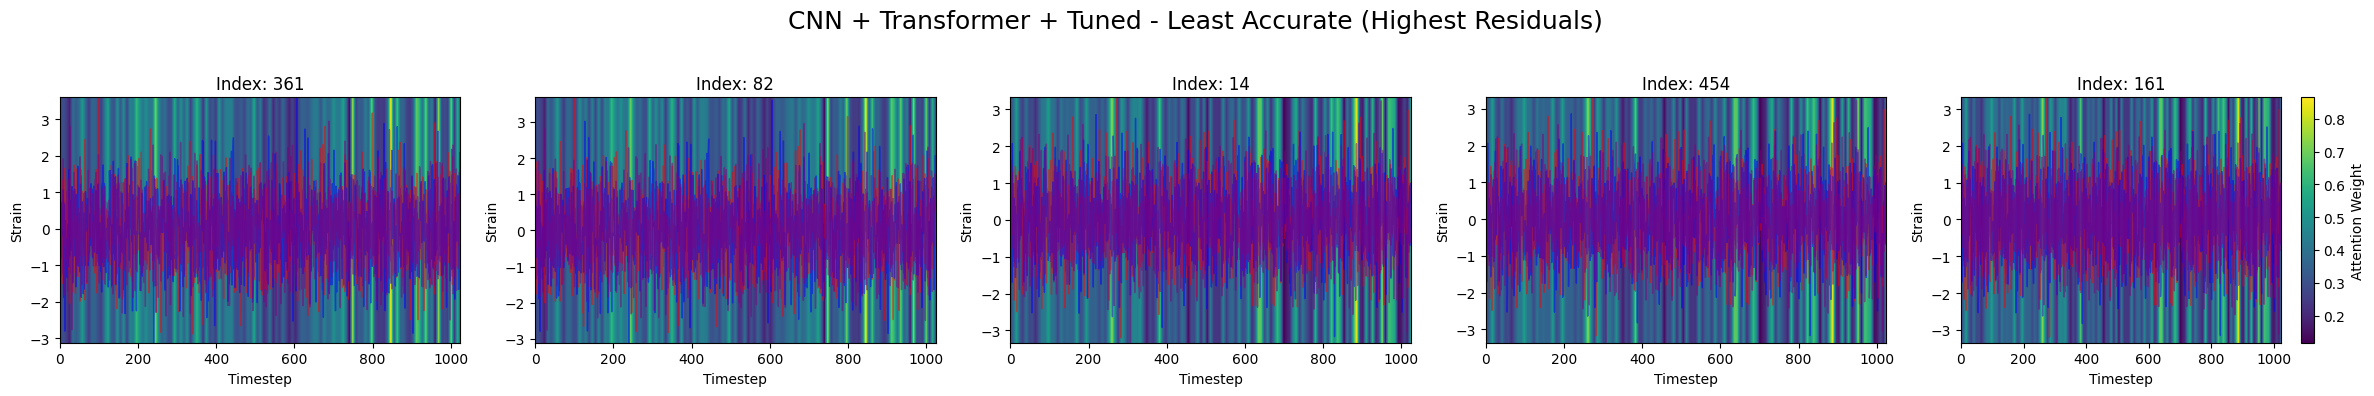

In [11]:
def visualize_cam_grid(model, model_name, X_test, corr_test, y_actual, scaler):
    # Compute residuals for each sample.
    residuals = []
    num_samples = len(X_test)
    for idx in range(num_samples):
        # Get the prediction for a single sample
        y_pred = predict_params_unscaled(model, X_test[idx], scaler)
        # Compute the total residual
        res = np.sum(np.abs(y_pred - y_actual[idx]))
        residuals.append(res)
    residuals = np.array(residuals)

    # Sort indices based on residuals: lowest first, highest last.
    sorted_indices = np.argsort(residuals)
    lowest_indices = sorted_indices[:5]   # top 5 most accurate samples
    highest_indices = sorted_indices[-5:]   # top 5 least accurate samples

    # Generate the CAM components for a given sample.
    def get_cam_components(sample_index):
        waveform_sample = X_test[sample_index]
        y_min, y_max = waveform_sample.min(), waveform_sample.max()

        # Build a CAM model that outputs
        cam_model = keras.Model(inputs=model.input, outputs=model.get_layer('cam_layer').output)
        # Predict CAM output
        cam_out = cam_model.predict([X_test[[sample_index]], corr_test[[sample_index]]])[0]
        cam_out = cam_out.squeeze()

        # Upsample CAM to match the waveform length
        num_points = waveform_sample.shape[0]
        x_old = np.linspace(0, num_points - 1, num=len(cam_out))
        x_new = np.arange(num_points)
        cam_upsampled = np.interp(x_new, x_old, cam_out)

        # Create a 2D heatmap by replicating the upsampled CAM
        heatmap = np.tile(cam_upsampled, (10, 1))
        return waveform_sample, heatmap, y_min, y_max

    # Plotting helper function to plot a horizontal row of 5 samples with a colorbar at the end.
    def plot_grid(indices, title):
        # Create a figure with 1 row and 5 columns
        fig, axs = plt.subplots(1, 5, figsize=(24, 4))
        fig.suptitle(f'{model_name} - {title}', fontsize=18)
        for i, sample_index in enumerate(indices):
            waveform_sample, heatmap, y_min, y_max = get_cam_components(sample_index)
            ax = axs[i]
            num_points = waveform_sample.shape[0]
            x = np.arange(num_points)
            # Plot the waveform channels.
            ax.plot(x, waveform_sample[:, 0], label='Hanford', color='red', linewidth=1, alpha=0.5)
            ax.plot(x, waveform_sample[:, 1], label='Livingston', color='blue', linewidth=1, alpha=0.5)
            ax.plot(x, waveform_sample[:, 2], label='Virgo', color='purple', linewidth=1, alpha=0.5)
            # Overlay the CAM heatmap.
            im = ax.imshow(heatmap, aspect='auto', cmap='viridis', alpha=1,
                           extent=[0, num_points, y_min, y_max], origin='lower')
            ax.set_title(f'Index: {sample_index}')
            ax.set_xlabel('Timestep')
            ax.set_ylabel('Strain')

        # Overlay the heatmap with imshow
        im = ax.imshow(heatmap, aspect='auto', cmap='viridis', alpha=1,
                       extent=[0, num_points, y_min, y_max],
                       origin='lower')
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Attention Weight')
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    # Plot the two grids:
    # 1. Most accurate (lowest residuals)
    plot_grid(lowest_indices, 'Most Accurate (Lowest Residuals)')
    # 2. Least accurate (highest residuals)
    plot_grid(highest_indices, 'Least Accurate (Highest Residuals)')

visualize_cam_grid(model_v1, 'CNN', X_test, corr_test, y_test, scaler)
visualize_cam_grid(cnn_tuned, 'CNN + Tuned', X_test, corr_test, y_test, scaler)
visualize_cam_grid(optimus_tuned, 'CNN + Transformer + Tuned', X_test, corr_test, y_test, scaler)

50/50 [==============================] - 1s 8ms/step


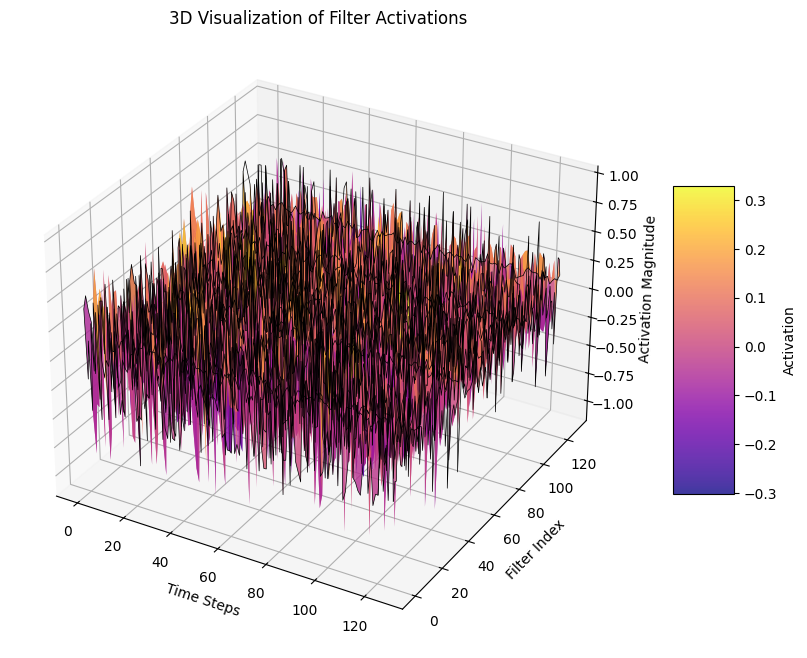

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose the filter index to maximize
filter_index = 0
# Define the layer name from which you want to extract activations (e.g., "conv1d")
layer_name = "multi_head_attention"

# Create an intermediate model that outputs the activations of the chosen layer
activation_model = tf.keras.Model(
    inputs=optimus_tuned.input,
    outputs=optimus_tuned.get_layer(layer_name).output
)

activations = activation_model.predict([X_val, corr_val])
T = activations.shape[1]
F = activations.shape[2]

# Create a meshgrid for plotting: time steps along x, filter index along y
time = np.arange(T)
filters = np.arange(F)
Time, Filters = np.meshgrid(time, filters)

# Reshape activations to (F, T) for plotting.
activation_values = activations[0].T  # shape becomes (F, T)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot a surface: adjust rstride and cstride for resolution if needed
surf = ax.plot_surface(Time, Filters, activation_values, cmap='plasma', edgecolor='none', alpha=0.8)

# Optionally, add a wireframe for additional detail:
ax.plot_wireframe(Time, Filters, activation_values, color='black', linewidth=0.5, rstride=10, cstride=10)

ax.set_xlabel('Time Steps')
ax.set_ylabel('Filter Index')
ax.set_zlabel('Activation Magnitude')
ax.set_title('3D Visualization of Filter Activations')

fig.colorbar(surf, shrink=0.5, aspect=5, label='Activation')
plt.show()

In [13]:
!pip install visualkeras
import visualkeras

  Obtaining dependency information for visualkeras from https://files.pythonhosted.org/packages/9b/6a/7dc8a7da9ba0b6fcb8e4043e9665827a1a9e910f99425f94a5c51b924762/visualkeras-0.1.4-py3-none-any.whl.metadata
  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/e0/d4/67f8f43db650ae54768ebbd5fa8a6327a985e59761e399fea92f0902bc9f/aggdraw-1.3.19-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 16.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


ValueError: Could not save to JPEG for display

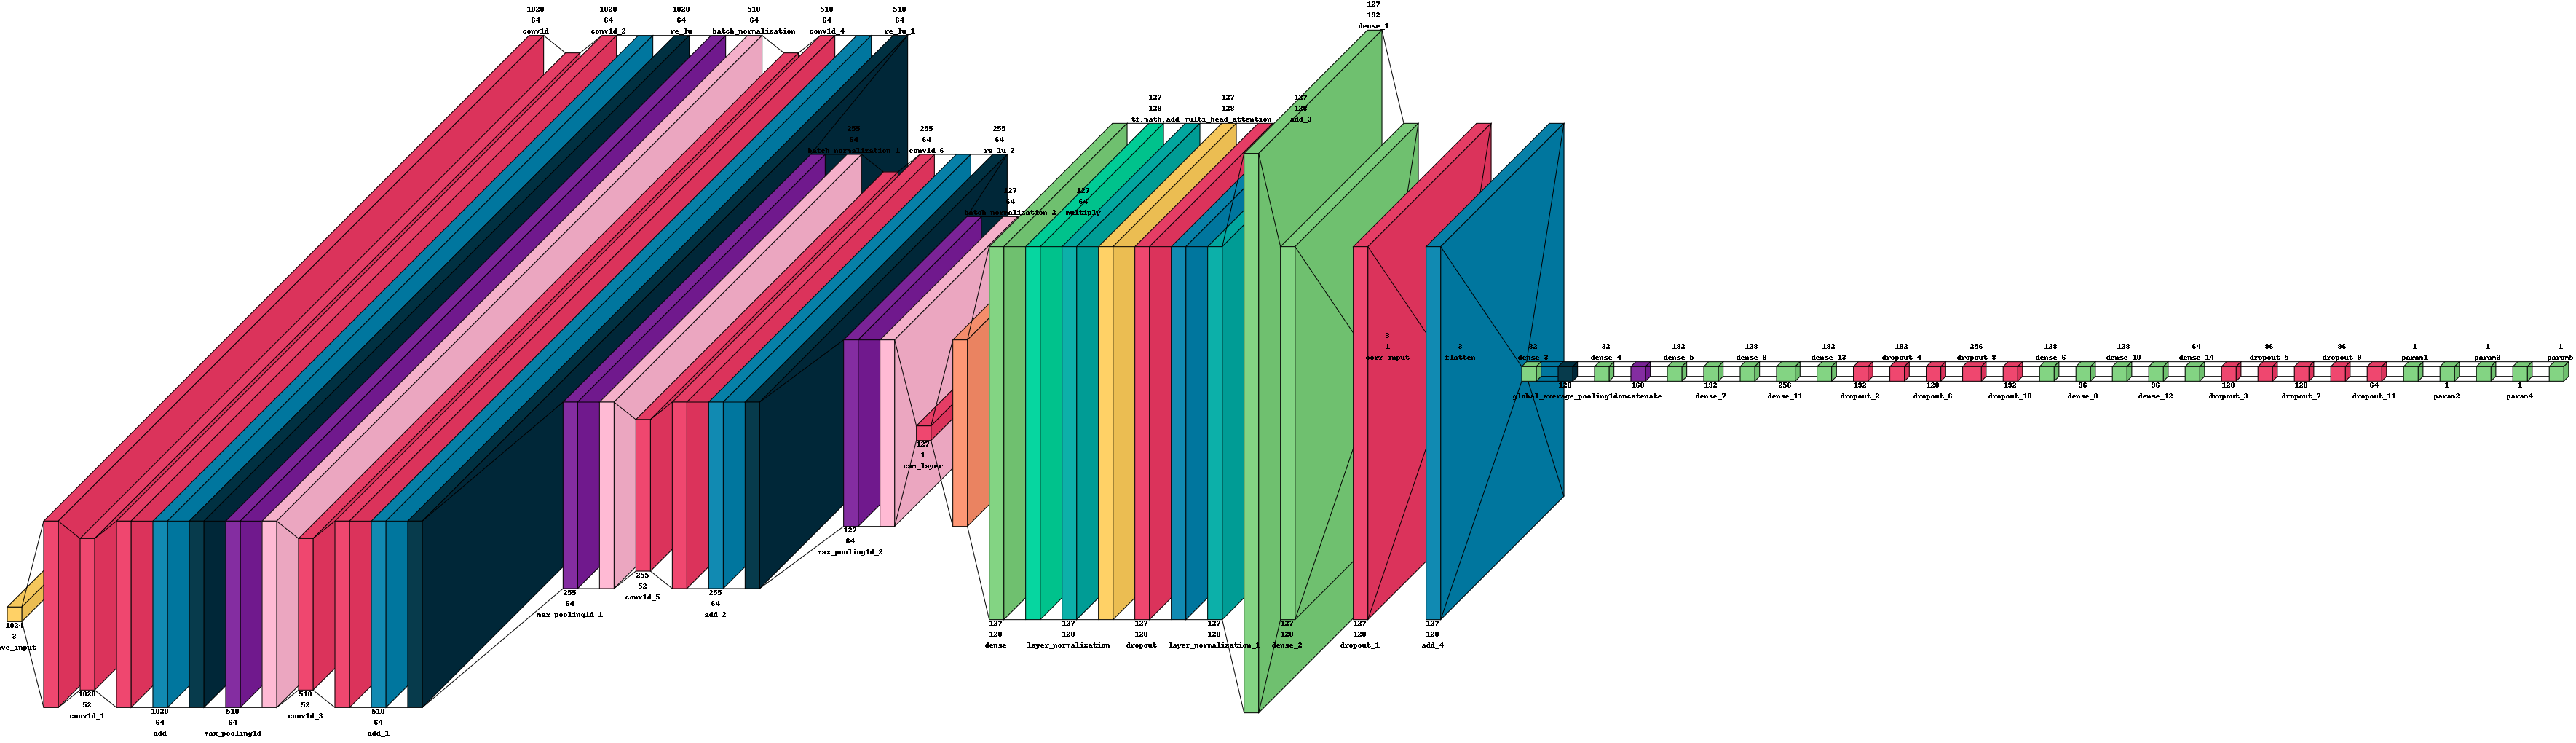

In [14]:
def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = bool(layer_index%2)

    # Get the output shape of the layer
    output_shape = [x for x in list(layer.output_shape) if x is not None]

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn    
    output_shape_txt = ""

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2: # Add an x between dimensions, e.g. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 2: # Add a newline between the last two dimensions, e.g. 3x3 \n 64
            output_shape_txt += "\n"

    # Add the name of the layer to the text, as a new line
    output_shape_txt += f"\n{layer.name}"

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above

# Then pass your function via the text_callback parameter:
visualkeras.layered_view(optimus_tuned, text_callable=text_callable, spacing=30, to_file='model_visualization.png')

In [15]:
optimus_tuned.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 wave_input (InputLayer)     [(None, 1024, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1020, 64)             1024      ['wave_input[0][0]']          
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1020, 52)             10036     ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 1020, 64)             10048     ['conv1d_1[0][0]']            
                                                                                              

In [16]:
model_v1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 wave_input (InputLayer)     [(None, 1024, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1018, 36)             792       ['wave_input[0][0]']          
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1018, 42)             4578      ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 1018, 36)             4572      ['conv1d_1[0][0]']            
                                                                                              